In [17]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import re
import nltk
from nltk.corpus import gutenberg
from nltk.tokenize import TreebankWordTokenizer
from sklearn.manifold import TSNE



In [18]:
nltk.download('gutenberg')
nltk.download('punkt')

# Charger et prétraiter le corpus (Hamlet)
raw_text = gutenberg.raw('shakespeare-hamlet.txt').lower()
text = re.sub(r'[^a-zA-Z\s]', ' ', raw_text)
tokenizer = TreebankWordTokenizer()
tokens = tokenizer.tokenize(text)



[nltk_data] Downloading package gutenberg to
[nltk_data]     C:\Users\Styx6/nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\Styx6/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


On récupère un texte brut TT (Hamlet).
On le met en minuscules pour éviter les doublons (Hello et hello doivent être vus comme le même mot).
On supprime la ponctuation (tous les caractères non alphabétiques sont remplacés par un espace).
On applique un tokenizer pour découper le texte en mots w1,w2,...,wnw1​,w2​,...,wn​.

In [19]:
vocab_size = 300
top_words = [word for word, _ in Counter(tokens).most_common(vocab_size)]
word2id = {word: i for i, word in enumerate(top_words)}
id2word = {i: word for word, i in word2id.items()}

On compte combien de fois chaque mot apparaît dans le texte.
On prend les NN mots les plus fréquents.
On crée un dictionnaire word2idword2id qui associe à chaque mot son index unique.

Formellement :
Si les mots "king" et "queen" apparaissent 100 et 80 fois respectivement:

    word2id = { "king": 0, "queen": 1 }
    id2word = { 0: "king", 1: "queen" }

In [21]:
# Construire la matrice de co-occurrence
def build_cooccurrence(tokens, word2id, window_size=2):
    vocab_size = len(word2id)
    cooccurrence = np.zeros((vocab_size, vocab_size), dtype=np.float32)
    
    for i, word in enumerate(tokens):
        if word not in word2id:
            continue
        center_id = word2id[word]
        for j in range(max(0, i - window_size), min(len(tokens), i + window_size + 1)):
            if i != j and tokens[j] in word2id:
                cooccurrence[center_id, word2id[tokens[j]]] += 1

    
    return cooccurrence

In [22]:
cooccurrence_matrix = build_cooccurrence(tokens, word2id, window_size=2)

In [32]:
class GloVe:
    def __init__(self, cooccurrence, word2id, vector_size=30, x_max=100, alpha=0.75):
        self.cooccurrence = cooccurrence
        self.word2id = word2id
        self.vector_size = vector_size
        self.vocab_size = len(word2id)
        self.x_max = x_max
        self.alpha = alpha
        
        self.W = np.random.randn(self.vocab_size, vector_size) * 0.1
        self.W_context = np.random.randn(self.vocab_size, vector_size) * 0.1
        self.b = np.zeros(self.vocab_size)
        self.b_context = np.zeros(self.vocab_size)
        self.loss_history = []
    
    def weight_func(self, x):
        return (x / self.x_max) ** self.alpha if x < self.x_max else 1.0
    
    def train(self, epochs=10, lr=0.05):
        pairs = [(i, j) for i in range(self.vocab_size) for j in range(self.vocab_size) if self.cooccurrence[i, j] > 0]
        for epoch in range(epochs):
            np.random.shuffle(pairs)
            loss = 0
            for i, j in pairs:
                X_ij = self.cooccurrence[i, j]
                weight = self.weight_func(X_ij)
                error = np.dot(self.W[i], self.W_context[j]) + self.b[i] + self.b_context[j] - np.log(X_ij)
                grad = weight * error
                self.W[i] -= lr * grad * self.W_context[j]
                self.W_context[j] -= lr * grad * self.W[i]
                self.b[i] -= lr * grad
                self.b_context[j] -= lr * grad
                loss += grad ** 2
            self.loss_history.append(loss / len(pairs))
            print(f"Époque {epoch+1}/{epochs}, Perte: {loss:.6f}")
        self.word_vectors = self.W + self.W_context
    
    def most_similar(self, word, n=5):
        if word not in self.word2id:
            return []
        word_vec = self.word_vectors[self.word2id[word]]
        sim = np.dot(self.word_vectors, word_vec) / (np.linalg.norm(self.word_vectors, axis=1) * np.linalg.norm(word_vec))
        return [(id2word[i], sim[i]) for i in np.argsort(sim)[::-1][1:n+1]]
    
    def plot_loss(self):
        plt.plot(self.loss_history)
        plt.title('Évolution de la perte')
        plt.xlabel('Époque')
        plt.ylabel('Perte')
        plt.show()
    
    def visualize(self, n=20):
        words = list(self.word2id.keys())[:n]
        vectors = self.word_vectors[:n]
        tsne = TSNE(n_components=2, perplexity=min(5, len(vectors) - 1), random_state=42)
        vectors_2d = tsne.fit_transform(vectors)
        plt.scatter(vectors_2d[:, 0], vectors_2d[:, 1], c='blue')
        for i, word in enumerate(words):
            plt.annotate(word, (vectors_2d[i, 0], vectors_2d[i, 1]))
        plt.title('Visualisation des embeddings GloVe')
        plt.show()

Époque 1/10, Perte: 603.894576
Époque 2/10, Perte: 182.529644
Époque 3/10, Perte: 134.081804
Époque 4/10, Perte: 120.391799
Époque 5/10, Perte: 108.346594
Époque 6/10, Perte: 101.092186
Époque 7/10, Perte: 91.476517
Époque 8/10, Perte: 83.989107
Époque 9/10, Perte: 76.025939
Époque 10/10, Perte: 69.484760


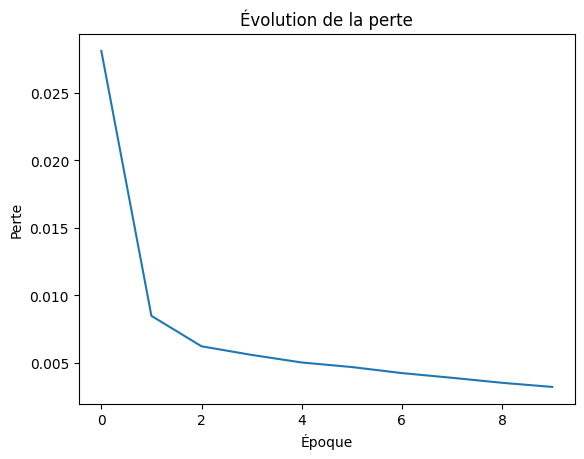

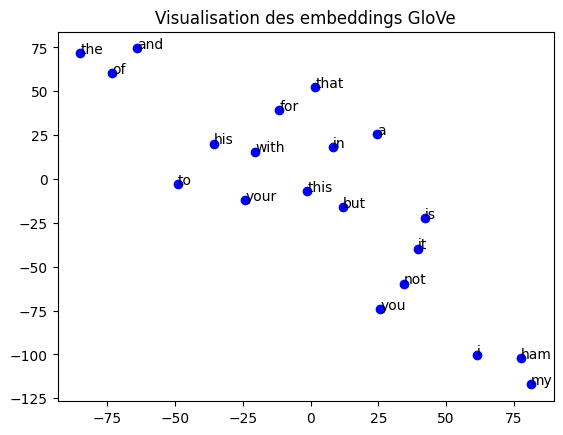

In [33]:
# Entraînement du modèle
model = GloVe(cooccurrence_matrix, word2id)
model.train()
model.plot_loss()
model.visualize()

In [31]:
# Tester les mots similaires
for word in ['hamlet', 'king', 'queen']:
    if word in word2id:
        print(f"\nMots similaires à '{word}':", model.most_similar(word))


Mots similaires à 'hamlet': [('oh', 0.4887211569489834), ('ham', 0.43439178422889396), ('yet', 0.3966491523251765), ('lord', 0.3870442578355687), ('long', 0.3739285723795592)]

Mots similaires à 'king': [('the', 0.6762654990516899), ('in', 0.6146298834266244), ('then', 0.5388698296462061), ('and', 0.522495909362454), ('is', 0.5191955273245165)]
